<a href="https://colab.research.google.com/github/mostafa-ja/LLM_from_scratch/blob/main/load_large_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`encode_ordinary(s)` is a method from the **`tiktoken`** library used specifically for GPT-style tokenization.

---

> 🔍 What It Does

```python
enc = tiktoken.get_encoding("gpt2")
enc.encode_ordinary(s)
```

This encodes the input string `s` into a list of **token IDs**, but **without** adding any *special tokens* like:

* `<|endoftext|>` (EOT)
* Padding or BOS/EOS tokens (if used in other contexts)

---

> ✅ Example

```python
enc = tiktoken.get_encoding("gpt2")
enc.encode_ordinary("Hello world")
# Output: [15496, 995]
```

* `15496` = "Hello"
* `995` = " world" (note the space)

Now compare that with a tokenizer that **adds special tokens**:

```python
enc.encode("Hello world")
# Output: [15496, 995, 50256]
```

* `50256` = `<|endoftext|>` (automatically appended)

So:

* `encode_ordinary(s)` → *pure* tokenization of the text, no extras.
* `encode(s)` → might add special tokens (like EOT) depending on settings.

---

> 🔧 Why Use `encode_ordinary`?

In many training pipelines, especially when you're manually managing formatting (like inserting EOTs), you want **full control**, so `encode_ordinary` is preferred.




Here's a **minimal example** showing how token sequences differ **with** and **without** the EOT token.

---

> ⚙ Setup

We'll compare tokenized output for two short "documents" using the GPT-2 tokenizer via `tiktoken`:

```python
import tiktoken

enc = tiktoken.get_encoding("gpt2")
eot = enc._special_tokens['<|endoftext|>']

doc1 = "To be or not to be."
doc2 = "That is the question."
```

---

> 🧪 1. **Without EOT**

```python
tokens = enc.encode_ordinary(doc1) + enc.encode_ordinary(doc2)
print(tokens)
```

**Output:**

```
[539, 389, 329, 703, 539, 13, 1804, 318, 262, 1123, 13]
```

* This is just the two texts glued together.
* The model may treat them as part of **one coherent sentence**, even though they're conceptually separate.

---

> 🧪 2. **With EOT Between Documents**

```python
tokens = [eot] + enc.encode_ordinary(doc1) + [eot] + enc.encode_ordinary(doc2)
print(tokens)
```

**Output (example):**

```
[50256, 539, 389, 329, 703, 539, 13, 50256, 1804, 318, 262, 1123, 13]
```

Here:

* `50256` is the EOT token for GPT-2.
* The model now sees two **clearly separated** text segments:

  * `[EOT] To be or not to be.`
  * `[EOT] That is the question.`

This helps the model reset context and avoid blending unrelated documents.

---

> 🧠 Why It Matters

Without EOT:

* The model may predict `"That"` as a continuation of `"To be or not to be."`

With EOT:

* The model is less likely to do that, since it sees a clear **document boundary**.

---



> 🤔 Why is the EOT placed **at the beginning** of each document (instead of at the end)?

```python
tokens.append(eot)  # prepend EOT
tokens.extend(encode(spad))  # then add the actual text
```

> 🧠 The Reason: **Training with autoregressive language models (like GPT-2)**

In **causal language modeling**, models are trained to predict the **next token** given all previous tokens.

That means:

* At training time, each token is predicted based on everything **to its left**.
* So, what you **put before** a sentence matters most.

---

> ✅ Why EOT at the Beginning Works

Putting an EOT **before** a new sentence acts as a **context reset**:

* It signals: “We’re starting a fresh, new document now.”
* The model learns: **"Whenever I see `<|endoftext|>`, forget what came before — I'm starting something new."**

> ❌ Why EOT at the End Isn't Enough

If you only put EOT **after** the sentence, it comes **too late**:

* The model would process the whole sentence **without knowing** it’s a new doc.
* It can carry over context from previous sentences — especially in long sequences.

---


In [1]:
!pip install datasets
!pip install huggingface_hub
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

# Dataset


> 🔍 What is FineWeb?

* **FineWeb** is a **massive cleaned and filtered web crawl dataset** derived from Common Crawl, processed with advanced filtering techniques (e.g., using classifier-based content filtering, de-duplication, boilerplate removal).
* Created by **Hugging Face Forward (HuggingFaceFW)** for training LLMs.
* The dataset is organized into multiple subsets like `fineweb-base`, `fineweb-edu`, `fineweb-code`, etc.

---

> 🎓 What is `fineweb-edu`?

* **`fineweb-edu`** is the **educational** slice of the FineWeb dataset.
* It includes web content categorized as **educational or academic**—typically from sources such as:

  * University domains (e.g., `.edu`)
  * Educational publishers
  * Scientific papers, lecture notes, syllabi
  * Open courseware
  * Instructional websites
* Filtered and scored using a **document classifier** trained to detect educational content with high precision.

---

> 📦 Key Features

* **High-quality**: Uses a multi-stage filtering process (e.g., document classifiers, NSFW filtering, de-duplication, heuristic rules).
* **Language-focused**: Primarily in **English**, though may contain multilingual content.
* **Large-scale**: Meant for training large-scale language models (like LLaMA, Falcon, Mistral).
* **Use Case**: Improves **reasoning**, **factual accuracy**, and **academic tone** in LLMs.

---

### 📘 Usage Example (Python/Hugging Face Datasets)

```python
from datasets import load_dataset

# Load dataset
fw = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train", streaming=True)
```

---



Let's break down this line:

```python
fw = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train", streaming=True)
```

This line uses the 🤗 Hugging Face `datasets` library to load a specific version of the `fineweb-edu` dataset. Here's what each parameter means:

---

### 🔍 Parameters Explained:

#### 1. `"HuggingFaceFW/fineweb-edu"`

* This is the **dataset identifier** on the Hugging Face Hub.
* It tells the loader to fetch the `fineweb-edu` dataset maintained by the `HuggingFaceFW` organization.

#### 2. `name="sample-10BT"`

* This specifies the **configuration** or **subset** of the dataset.
* `"sample-10BT"` refers to a sample version from the **10 trillion tokens (10T)** scale of the **FineWeb dataset**.

  * It's not the full 10T version, but a representative **sample**.
  * Useful for debugging, testing training pipelines, or fine-tuning on a smaller educational subset.

#### 3. `split="train"`

* Specifies which **split** of the dataset to load.
* Most web-scale datasets use just `"train"` since they’re not typically divided into train/test/validation.

#### 4. `streaming=True`

* This enables **streaming mode**, which:

  * **Loads data lazily**, one example at a time.
  * Does **not download the full dataset upfront**—great for huge datasets.
  * Ideal for working with **massive corpora** like FineWeb that are too large to fit into memory or local disk.
  * Requires you to iterate over the dataset using a loop, e.g.:

    ```python
    for doc in fw:
        print(doc)
        break
    ```

---



In [2]:
from datasets import load_dataset

# Load dataset
fw = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train", streaming=True)

for doc in fw:
  print(doc)
  break

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

{'text': 'The Independent Jane\nFor all the love, romance and scandal in Jane Austen’s books, what they are really about is freedom and independence. Independence of thought and the freedom to choose.\nElizabeth’s refusal of Mr. Collins offer of marriage showed an independence seldom seen in heroines of the day. Her refusal of Mr. Darcy while triggered by anger showed a level of independence that left him shocked and stunned.\nThe freedom she exhibited in finally accepting him in direct defiance of Lady Catherine and knowing her father would disapprove was unusual even for Austen. In her last book Anne Elliot is persuaded to refuse Captain Wentworth at Lady Russel’s insistence.\nAlthough Jane played by the rules of the day, all of her writing is infused with how she wanted life to be. She ‘screams’ her outrage at the limitations for women in Emma.\nWhen accosted by Mrs. Elton, Jane Fairfax says,\n“Excuse me, ma’am, but this is by no means my intention; I make no inquiry myself, and sho

In [4]:
doc.keys()

dict_keys(['text', 'id', 'dump', 'url', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'])

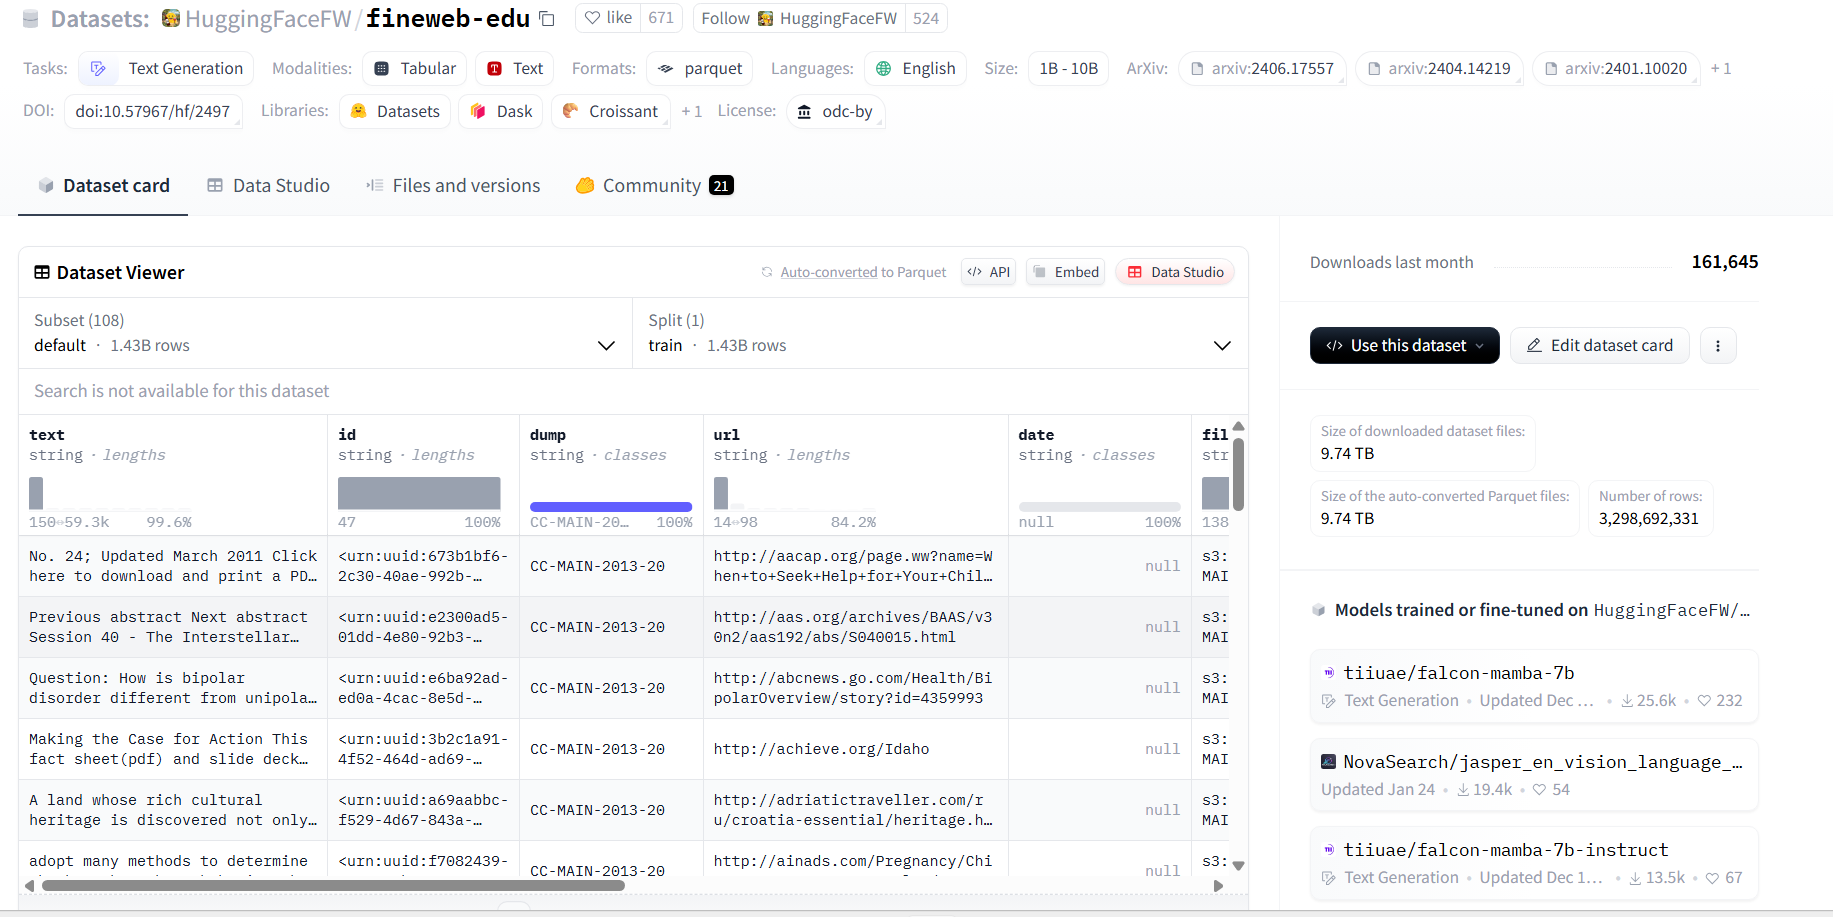

Great question — when you load a document from the `HuggingFaceFW/fineweb-edu` dataset (e.g., using `for doc in fw:`), each document is returned as a dictionary with the following keys:

```python
dict_keys(['text', 'id', 'dump', 'url', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'])
```

Here’s what each of these fields represents:

---

### 📄 Document Fields Explained:

#### 1. **`text`**

* The **raw textual content** of the document.
* Cleaned and processed (e.g., boilerplate removed).
* This is the main content you'll pass to the model.

#### 2. **`id`**

* A **unique identifier** for the document.
* Often a hash or string key used to track the document across processing steps or avoid duplication.

#### 3. **`dump`**

* Indicates the **source crawl** or **Common Crawl dump ID** where the document was extracted from.
* Example: `"CC-MAIN-2023-10"` — helps identify when and from where the data was collected.

#### 4. **`url`**

* The **original URL** of the web page from which the content was extracted.
* Useful for tracing the provenance of the data or filtering based on domain.

#### 5. **`file_path`**

* Path to the **source WARC file** or internal storage path within the dataset.
* Can be used for reprocessing or auditing the original source content.

#### 6. **`language`**

* Detected **language** of the document, typically a **2-letter ISO code** (e.g., `"en"` for English).
* Multilingual content is possible, but `fineweb-edu` is primarily English.

#### 7. **`language_score`**

* A **confidence score** from the language detection model.
* Ranges from 0 to 1 — higher means more confident in the language label.

#### 8. **`token_count`**

* Estimated or computed number of **tokens** in the document.
* Helpful for:

  * Batching during training
  * Filtering short/long documents
  * Estimating compute/storage needs

#### 9. **`score`**

* A **float quality score** assigned by HuggingFace’s document classifier.
* Reflects the **document’s usefulness** (e.g., educational value, quality, informativeness).
* Usually between 0 and 1.

#### 10. **`int_score`**

* An **integer bucket version** of `score` (e.g., for faster filtering or stratification).
* Often used for coarse filtering (e.g., keep only documents with `int_score >= 3`).

---

### ✅ Summary Use Case

If you're training a model, the most relevant fields are:

* `text`: for the input itself.
* `language` / `language_score`: for filtering non-English content.
* `score` / `int_score`: for quality filtering (e.g., use only high-score docs).
* `token_count`: for sampling or batching logic.

---



# Extract data

This script is designed to **efficiently tokenize and shard a large-scale dataset** (like `fineweb-edu`) **without consuming too much memory**. Here's a detailed explanation of how and why this works:

---

> 🧠 **What’s the Goal?**

You're streaming a **massive dataset** (`fineweb-edu`) and want to:

* **Tokenize** the text using GPT-2 tokenizer.
* **Convert it to NumPy arrays** (using `uint16` to reduce memory usage).
* **Split it into manageable shards** (e.g., 100M tokens per file).
* Store on disk without ever loading the full dataset into RAM.

---

>  🔄 **Key Ideas and Why It Works**

> ✅ **1. Streaming (`streaming=True`)**

* Dataset is loaded lazily, one document at a time.
* **No need to load everything into memory**, which would be infeasible for billions of tokens.

> ✅ **2. Tokenizing On-the-Fly**

* `tokenize(doc)` encodes each document into GPT-2 tokens.
* Adds the `<|endoftext|>` token at the start.
* Converts to `np.uint16` (saves 50% memory vs `np.uint32`, since GPT-2 vocab size < 65,536).

> ✅ **3. Sharding Strategy**

* Uses a buffer `shard_tokens` of size `shard_size * 2` (to handle overflow).
* When buffer exceeds `shard_size` (e.g., 100M tokens), it:

  * Saves current buffer to disk (as `.npy`).
  * Clears the buffer and continues.
* First shard is used as **validation (`val`)**, others as **training (`train`)**.

> ✅ **4. Disk-Based Output**

* Files are saved as `edufineweb_train_XX.npy` or `edufineweb_val_00.npy`.
* Stored in a local folder (`./dataset`).
* These `.npy` files are very efficient for loading during training.

---


## 📊 Example File Output

After running the script, you'd have:

```
dataset/
├── edufineweb_val_00.npy     # First 100M tokens
├── edufineweb_train_01.npy   # Next 100M
├── edufineweb_train_02.npy   # ...
```

These files can be directly loaded later for efficient model training.

---


In [ ]:
import os
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import tiktoken

# ------------------------------------------
shard_size = int(1e8)  # 100M tokens
TOTAL_TOKENS = int(5e9)  # 5B tokens total

# Create local directory
os.makedirs('dataset', exist_ok=True)

# Load dataset
fw = load_dataset("HuggingFaceFW/fineweb-edu", name="sample-10BT", split="train", streaming=True)

# Initialize tokenizer
enc = tiktoken.get_encoding("gpt2")
eot = enc._special_tokens['<|endoftext|>']

def tokenize(doc):
    tokens = [eot]
    tokens.extend(enc.encode_ordinary(doc["text"]))
    return np.array(tokens, dtype=np.uint16) # we convert to np.uint16, for occupying less memory

def write_datafile(filename, tokens_np):
    np.save(filename, tokens_np)


In [ ]:

# Processing loop
shard_index = 0
shard_tokens = np.empty(shard_size * 2, dtype=np.uint16)  # extra room for spillover
num_shard_tokens = 0
accu_tokens = 0

progress_bar = tqdm(total=TOTAL_TOKENS / 1e6, unit="M tokens", desc="Processing", dynamic_ncols=True, leave=True)

for doc in fw:
    if accu_tokens >= TOTAL_TOKENS:
        break

    tokens = tokenize(doc)
    num_tokens = len(tokens)
    accu_tokens += num_tokens

    # If current buffer won't fit new tokens, flush first
    if num_shard_tokens + num_tokens > shard_size:
        split = "val" if shard_index == 0 else "train"
        filename = os.path.join('dataset', f"edufineweb_{split}_{shard_index:02d}")
        write_datafile(filename, shard_tokens[:num_shard_tokens])
        shard_index += 1

        # Reset buffer
        num_shard_tokens = 0

    # Store tokens into shard buffer
    shard_tokens[num_shard_tokens:num_shard_tokens + num_tokens] = tokens
    num_shard_tokens += num_tokens

    progress_bar.update(num_tokens / 1e6)

# Save any remaining tokens
if num_shard_tokens > 0:
    split = "val" if shard_index == 0 else "train"
    filename = os.path.join('dataset', f"edufineweb_{split}_{shard_index:02d}")
    write_datafile(filename, shard_tokens[:num_shard_tokens])

# New Section

This code defines a memory-efficient PyTorch `IterableDataset` called `ShardStreamingDataset`, designed for **streaming large tokenized datasets from disk** — particularly for training language models like GPT. Here's a clear breakdown:

---

## 🔹 Imports

```python
import os
import numpy as np
from torch.utils.data import IterableDataset
```

* `os`: for file operations (not directly used here but often needed)
* `numpy`: for loading `.npy` files (containing token arrays)
* `IterableDataset`: a PyTorch base class used when data is streamed rather than indexed

---

## 🔹 Class: `ShardStreamingDataset`

```python
class ShardStreamingDataset(IterableDataset):
```

This class creates a **streaming dataset** that:

* Loads **one `.npy` shard at a time**
* Iterates over it in order
* Yields token sequences for training

---

### `__init__`: Configuration

```python
def __init__(self, shard_paths, seq_len=2048, shuffle_files=True, infinite=True):
```

| Parameter       | Purpose                                                      |
| --------------- | ------------------------------------------------------------ |
| `shard_paths`   | List of `.npy` file paths (each storing tokenized data)      |
| `seq_len`       | Length of each input/target sequence pair                    |
| `shuffle_files` | If `True`, randomize the order of shards each epoch          |
| `infinite`      | If `True`, keep looping over the data forever (for training) |

---

### `_load_shard`: Yield sequences from a single file

```python
def _load_shard(self, path):
    data = np.load(path, mmap_mode='r+')
```

* **`mmap_mode='r'`** means memory mapping — the file is not fully loaded into RAM.
* `data` is a 1D array of token IDs.
* `'r+'` Loads the file in read-write mode. proper to tensor

```python
    num_tokens = len(data)
    max_start = num_tokens - self.seq_len - 1
```

* Calculate the last valid start index so we don’t go out of bounds when slicing.

```python
    if max_start <= 0:
        return  # Skip shards that are too small
```

### Iterate sequentially through the file

```python
    for start in range(0, max_start + 1, self.seq_len):
        end = start + self.seq_len + 1
        if end > num_tokens:
            break
        chunk = data[start:end]
```

* Step through the array in strides of `seq_len`
* Extract `seq_len + 1` tokens at a time:

  * First `seq_len` → `input_ids`
  * Shifted by one → `target_ids` (for next-token prediction)

```python
        input_ids = chunk[:-1]
        target_ids = chunk[1:]
        yield input_ids, target_ids
```

* **Yield a tuple of token arrays** (input and target) for the model.

---

### `__iter__`: Main generator loop

```python
def __iter__(self):
    while True:
        file_paths = list(self.shard_paths)
        if self.shuffle_files:
            np.random.shuffle(file_paths)
```

* Optionally shuffle the file order on each pass.

```python
        for path in file_paths:
            yield from self._load_shard(path)
```

* For each shard, yield all sequences using `_load_shard`.

```python
        if not self.infinite:
            break
```

* If not `infinite`, stop after one full pass over all shards.
* If `infinite`, loop forever (commonly used during training).

---

## 🔁 What Does It Yield?

Each call to the `DataLoader` will get batches of:

```python
(input_ids, target_ids)
```

Where:

* `input_ids` is a sequence of `seq_len` token IDs
* `target_ids` is the next-token version of `input_ids`, shifted left by 1

---

## ✅ Summary

This class:

* Efficiently streams large datasets stored in `.npy` files
* Supports both training and evaluation modes
* Uses **very little RAM**, even with multi-GB datasets
* Works seamlessly with PyTorch `DataLoader`

---



We use `**yield**` instead of `**return**` in `ShardStreamingDataset` because we want to produce **a sequence of values over time** — not just one. This makes the function a **generator**, which is ideal for:

---

### ✅ **Efficient Streaming**

With `yield`, the function:

* Produces one `(input_ids, target_ids)` pair **at a time**
* **Pauses** after each yield
* **Resumes** where it left off on the next iteration

This avoids loading the entire dataset into memory, which is critical for massive corpora (like tokenized `.npy` files from `FineWeb`).

---

### 🔄 Difference Between `yield` and `return`

| Feature       | `return`                            | `yield`                                           |
| ------------- | ----------------------------------- | ------------------------------------------------- |
| Returns       | One single value and exits          | A generator that can return many values over time |
| Memory use    | Loads all data at once (if looping) | Loads one item at a time (lazy loading)           |
| Function ends | Immediately after `return`          | Suspends and can resume after `yield`             |
| Use case      | Small, complete computations        | Large or infinite datasets                        |

---

### 📦 In PyTorch IterableDataset

PyTorch's `IterableDataset` expects `__iter__()` to be a **generator** — not a fixed list — especially when:

* You don’t know the total size in advance
* You're streaming or processing data dynamically
* You want to cycle forever (`infinite=True`)

Example:

```python
def __iter__(self):
    for file in files:
        yield from self._load_shard(file)
```

Each call to `yield` sends a sample to the DataLoader **without needing the entire set in memory.**

---




In [ ]:
import os
import numpy as np
from torch.utils.data import IterableDataset

class ShardStreamingDataset(IterableDataset):
    def __init__(self, shard_paths, seq_len=1024, shuffle_files=False, infinite=True):
        self.shard_paths = shard_paths
        self.seq_len = seq_len
        self.shuffle_files = shuffle_files
        self.infinite = infinite

    def _load_shard(self, path):
        data = np.load(path, mmap_mode='r+')
        num_tokens = len(data)
        max_start = num_tokens - self.seq_len - 1  # -1 for target shift

        if max_start <= 0:
            return  # Skip short shards

        # Process sequences in order, no shuffling
        for start in range(0, max_start + 1, self.seq_len):
            end = start + self.seq_len + 1
            if end > num_tokens:
                break
            chunk = data[start:end]
            input_ids = chunk[:-1]
            target_ids = chunk[1:]
            yield input_ids, target_ids

    def __iter__(self):
        while True:
            file_paths = list(self.shard_paths)
            if self.shuffle_files:
                np.random.shuffle(file_paths)

            for path in file_paths:
                yield from self._load_shard(path)

            if not self.infinite:
                break

In [ ]:
from torch.utils.data import DataLoader

train_files = sorted([f'/content/drive/MyDrive/Untitled Folder/{f}' for f in os.listdir('/content/drive/MyDrive/Untitled Folder/') if 'train' in f])
val_files = sorted([f'/content/drive/MyDrive/Untitled Folder/{f}' for f in os.listdir('/content/drive/MyDrive/Untitled Folder/') if 'val' in f])

train_dataset = ShardStreamingDataset(train_files, seq_len=1024, shuffle_files=False, infinite=True)
val_dataset = ShardStreamingDataset(val_files, seq_len=1024, shuffle_files=False, infinite=False)

train_loader = DataLoader(train_dataset, batch_size=2048, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True)